# Convolutional Neural Network
This notebook contains code for training and evaluating the CNN-based models of the project.

## Imports

In [2]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data loader / preprocessing
from src import (
    load_depresjon,
    load_psykose,
    load_joint_dataset,
    convert_to_torch,
    manual_feature_builder,
    pad_sequencer,
    convert_torch_tensor_to_array,
    get_class_weights,
    f1_weighted,
    get_label,
)
from sklearn.preprocessing import StandardScaler

# CNN
import torch
import keras as keras
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelBinarizer
from keras.layers import (
    Input,
    Conv1D,
    Conv2D,
    GlobalMaxPooling1D,
    GlobalMaxPooling2D,
    Dense,
    Attention,
    Flatten,
    BatchNormalization,
    Dropout,
)
from keras import backend as K
from keras.utils.vis_utils import plot_model  # need to install graphviz

# Evaluation
from sklearn import metrics
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    make_scorer,
)

# Gramian AngularField
from pyts.image import GramianAngularField

## Load data
Here, we load the data. Notice that we specify `slicer_seq=False` in the `convert_to_torch` function, meaning that a data point consists of the entire sequence of a subject's motor activity sequence.

In [449]:
df = load_joint_dataset()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = convert_to_torch(
    df,
    slice_seq=False,
    preprocessing="average",
    k=10,
    train_perc=0.60,
    val_perc=0.20,
    random_seed=42,
    device=device,
)
train_data, val_data, test_data = data
X_train, y_train = list(zip(*train_data))
X_val, y_val = list(zip(*val_data))
X_test, y_test = list(zip(*test_data))

2022-12-21 19:57:03.722 | INFO     | load_data:load_depresjon:36 - Loading depresjon
2022-12-21 19:57:06.738 | INFO     | load_data:load_psykose:54 - Loading psykose
2022-12-21 19:57:07.666 | INFO     | load_data:load_hyperaktiv:72 - Loading hyperaktiv
2022-12-21 19:58:22.974 | INFO     | load_data:convert_to_torch:222 - Converting to torch
2022-12-21 19:58:22.975 | INFO     | load_data:convert_to_torch:225 - Filtering out problematic dates
2022-12-21 19:58:36.194 | INFO     | load_data:convert_to_torch:248 - Averaging activity sequences
2022-12-21 19:58:38.185 | INFO     | load_data:train_val_test_split:188 - Split dataset into
   Training set:
      59.49% of total sequences
      Subjects: ADHD: 36, ADHD_Control: 36, DEPR_Control: 27, SZ: 16, DEPR: 18
   Validation set:
      20.20% of total sequences
      Subjects: ADHD: 9, ADHD_Control: 4, DEPR_Control: 5, DEPR: 5, SZ: 6
   Test set:
      20.31% of total sequences
      Subjects: DEPR_Control: 7, ADHD: 7, ADHD_Control: 6, SZ: 5,

## Need to pad the sequence

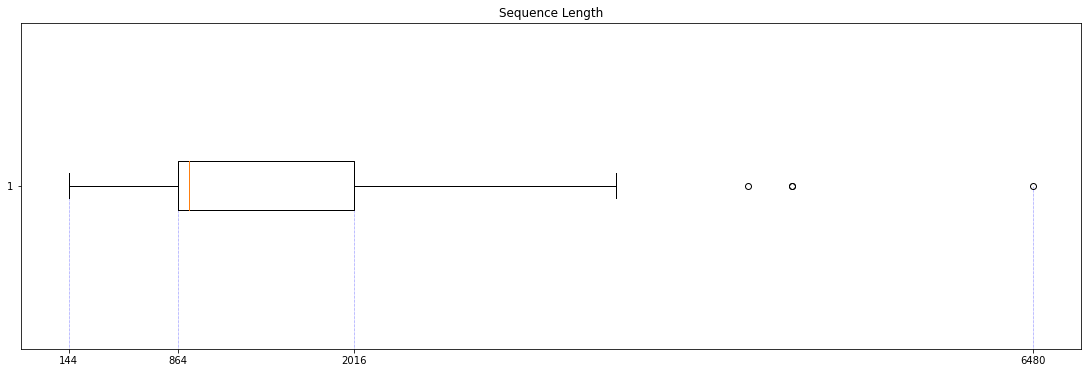

In [638]:
# Plot the distribution of sequence lengths
lengths = []
for i in range(len(X_train)):
    lengths.append((len(X_train[i])))

fig = plt.figure(1, figsize=(19, 6))
ax = fig.add_subplot(111)

ax.boxplot(lengths, vert=False, manage_ticks=True)
plt.title("Sequence Length")
ax.set_yticks([1])

quantiles = np.quantile(lengths, np.array([0.00, 0.25, 0.75, 1.00]))
ax.vlines(
    quantiles,
    [0] * quantiles.size,
    [1] * quantiles.size,
    color="b",
    ls=":",
    lw=0.5,
    zorder=0,
)
ax.set_ylim(0.5, 1.5)
ax.set_xticks(quantiles)
plt.show()

Sequences will all be made to the length of the length of the third quartile - i.e 2016 observations. Shorter sequences will be padded with zeros while longer sequences will be truncated. 

In [639]:
# Pad sequences
X_train_padded = pad_sequencer(X_train)
X_val_padded = pad_sequencer(X_val)
X_test_padded = pad_sequencer(X_test)

# Convert labels from Torch Tensor to Numpy Array
y_train = convert_torch_tensor_to_array(y_train)
y_val = convert_torch_tensor_to_array(y_val)
y_test = convert_torch_tensor_to_array(y_test)

# Convert shape from (#observations, #sequence_length, 1) to (#observations, #sequence_length)
X_train_padded = np.squeeze(X_train_padded)
X_val_padded = np.squeeze(X_val_padded)
X_test_padded = np.squeeze(X_test_padded)

print(X_train_padded.shape)
print(X_val_padded.shape)
print(X_test_padded.shape)

(104, 2048)
(29, 2048)
(29, 2048)


In [16]:
# Get class weights to weigh the training
y_train, d_class_weights = get_class_weights(y_train)

## Create the model

In [456]:
# Define the input layer
inputs = Input(shape=(2048, 1))  # shape=(timesteps, features)

# Add a 1D convolutional layer with 64 filters and a kernel size of 3
x = BatchNormalization()(inputs)
x = Conv1D(16, 2, strides=1, padding="same", activation="relu")(x)
x = Conv1D(32, 3, strides=1, padding="same", activation="relu")(x)
# x = Conv1D(64, 3, strides=1, activation='relu')(x)
x = BatchNormalization()(x)
x = GlobalMaxPooling1D()(x)  # Add a global max pooling layer
# x = Dropout(rate=0.2)(x)
x = Flatten()(x)

# Final two dense layers
x = Dense(12, activation="relu")(x)
x = Dense(12, activation="relu")(x)
outputs = Dense(4, activation="softmax")(x)

# Create the model
model = keras.Model(inputs, outputs)

# Optimizer
# opt = tf.keras.optimizers.Adam(learning_rate=0.001)
opt = tf.keras.optimizers.SGD(0.001, momentum=0.9)

# Compile the model with an optimizer and a loss function
model.compile(
    optimizer=opt, loss="categorical_crossentropy", metrics=["acc", f1_weighted]
)
model.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 2048, 1)]         0         
                                                                 
 batch_normalization_64 (Bat  (None, 2048, 1)          4         
 chNormalization)                                                
                                                                 
 conv1d_36 (Conv1D)          (None, 2048, 16)          48        
                                                                 
 conv1d_37 (Conv1D)          (None, 2048, 32)          1568      
                                                                 
 batch_normalization_65 (Bat  (None, 2048, 32)         128       
 chNormalization)                                                
                                                                 
 global_max_pooling1d_15 (Gl  (None, 32)               0  

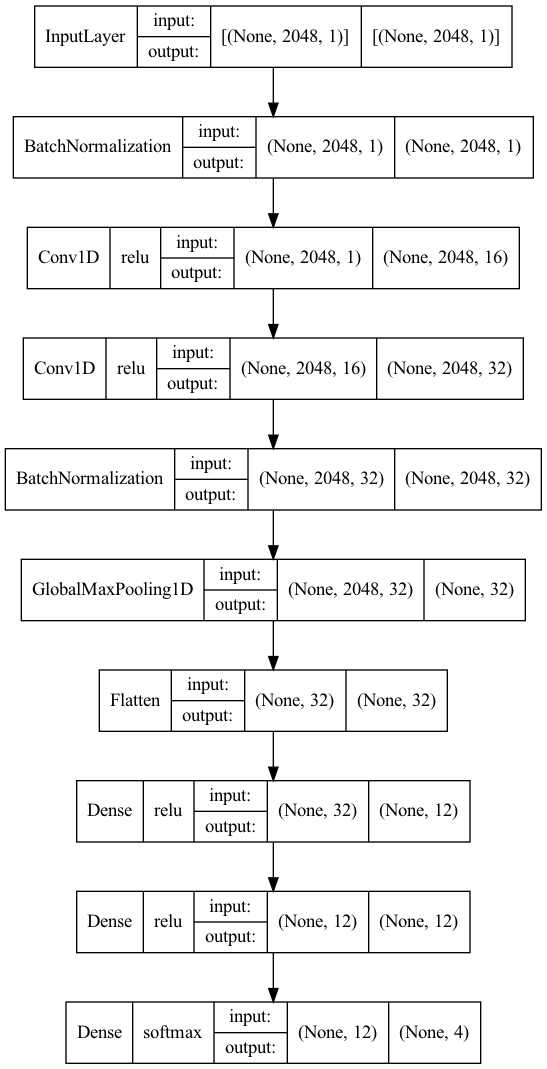

In [457]:
# Plot model architecture
plot_model(
    model,
    to_file="model_plot.png",
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
)

In [458]:
# Fit the model on the training data

# Using class weights to deal with the class imbalances:
# class_weight: Optional dictionary mapping class indices (integers) to a weight (float)
# value, used for weighting the loss function (during training only). This can be useful
# to tell the model to "pay more attention" to samples from an under-represented class.
# The weights were retrieved in the get_class_weights function higher up in this notebook

history = model.fit(
    X_train_padded,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val_padded, y_val),
    class_weight=d_class_weights,
)

Epoch 1/50
4/4 [==============================] - 1s 120ms/step - loss: 2.3082 - acc: 0.3269 - f1_weighted: 0.1823 - val_loss: 2.2790 - val_acc: 0.2069 - val_f1_weighted: 0.1707
Epoch 2/50
4/4 [==============================] - 0s 59ms/step - loss: 1.6918 - acc: 0.1346 - f1_weighted: 0.2184 - val_loss: 1.6181 - val_acc: 0.2759 - val_f1_weighted: 0.2509
Epoch 3/50
4/4 [==============================] - 0s 57ms/step - loss: 1.6069 - acc: 0.2500 - f1_weighted: 0.2579 - val_loss: 1.6526 - val_acc: 0.2759 - val_f1_weighted: 0.2496
Epoch 4/50
4/4 [==============================] - 0s 64ms/step - loss: 1.4498 - acc: 0.2692 - f1_weighted: 0.2995 - val_loss: 1.4976 - val_acc: 0.2759 - val_f1_weighted: 0.2645
Epoch 5/50
4/4 [==============================] - 0s 63ms/step - loss: 1.3872 - acc: 0.3173 - f1_weighted: 0.2974 - val_loss: 1.4067 - val_acc: 0.2759 - val_f1_weighted: 0.2783
Epoch 6/50
4/4 [==============================] - 0s 65ms/step - loss: 1.3501 - acc: 0.3365 - f1_weighted: 0.2896 

In [459]:
# Predict on test set
y_pred = np.argmax(model.predict(X_test_padded), axis=1)

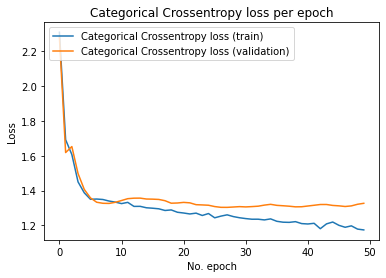

In [460]:
# Plot training and validation loss during training
plt.plot(history.history["loss"], label="Categorical Crossentropy loss (train)")
plt.plot(history.history["val_loss"], label="Categorical Crossentropy loss (validation)")
plt.title("Categorical Crossentropy loss per epoch")
plt.ylabel("Loss")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

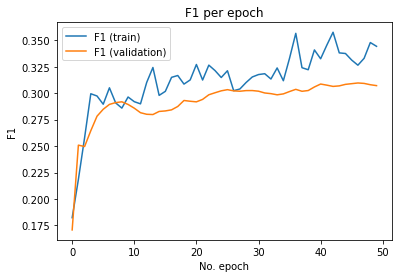

In [461]:
# Plot training and validation f1 scores during training
plt.plot(history.history["f1_weighted"], label="F1 (train)")
plt.plot(history.history["val_f1_weighted"], label="F1 (validation)")
plt.title("F1 per epoch")
plt.ylabel("F1")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

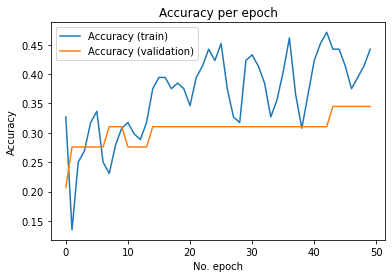

In [462]:
# Plot training and validation auccracy during training
plt.plot(history.history["acc"], label="Accuracy (train)")
plt.plot(history.history["val_acc"], label="Accuracy (validation)")
plt.title("Accuracy per epoch")
plt.ylabel("Accuracy")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

In [463]:
# Compute accuracy score on tewst set
accuracy = round(accuracy_score(np.argmax(y_test, axis=1), y_pred), 4)
print("Accuracy: " + str(accuracy))

# Compute precision score on test set
precision = round(precision_score(np.argmax(y_test, axis=1), y_pred, average="weighted"), 4)
print("Precision: " + str(precision))

# Compute F1 score on test set
F1 = round(f1_score(np.argmax(y_test, axis=1), y_pred, average="weighted"), 4)
print("Weighted F1: " + str(F1))

Accuracy: 0.5172
Precision: 0.2956
Weighted F1: 0.3762


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 15.0, 'Pred')

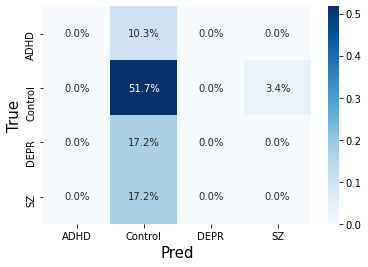

In [464]:
# Plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(
    cm / np.sum(cm),
    annot=True,
    fmt=".1%",
    cmap="Blues",
    xticklabels=["ADHD", "Control", "DEPR", "SZ"],
    yticklabels=["ADHD", "Control", "DEPR", "SZ"],
)
plt.ylabel("True", fontsize=15)  # x-axis label with fontsize 15
plt.xlabel("Pred", fontsize=15)  # y-axis label with fontsize 15

## Convolutional neural network  with Gramian Angular Fields

In [642]:
# Convert our 1D time series to an image using Gramian Angular Fields
X_train_padded

array([[128,  58,  73, ...,   0,   0,   0],
       [919, 458,   7, ...,   0,   0,   0],
       [ 46,  27,   9, ...,   0,   0,   0],
       ...,
       [161,  70, 488, ...,   0,   0,   0],
       [  6,   6,   6, ...,   0,   0,  20],
       [ 42,  32,  10, ...,   0,   0,   0]], dtype=int32)

<Figure size 432x288 with 0 Axes>

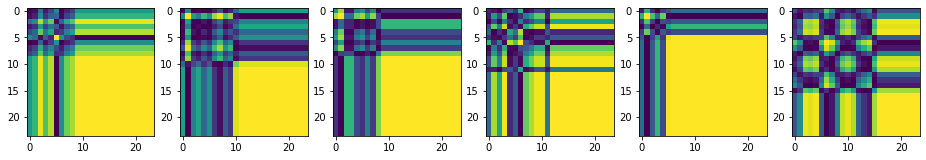

<Figure size 432x288 with 0 Axes>

In [643]:
# Define GAF
gaf = GramianAngularField(image_size=24)

# X_train
im_train = gaf.fit_transform(X_train_padded)
im_train = np.expand_dims(im_train, axis=-1)

# X_val
im_val = gaf.transform(X_val_padded)
im_val = np.expand_dims(im_val, axis=-1)

# X_test
im_test = gaf.transform(X_test_padded)
im_test = np.expand_dims(im_test, axis=-1)

# Plot new data representation
f, axarr = plt.subplots(1, 6, figsize=(16, 16))
axarr[0].imshow(im_train[0])
axarr[1].imshow(im_train[1])
axarr[2].imshow(im_train[2])
axarr[3].imshow(im_train[3])
axarr[4].imshow(im_train[4])
axarr[5].imshow(im_train[5])

plt.figure()

In [644]:
# Get sizes of new data representation
print(im_train.shape)
print(im_val.shape)
print(im_test.shape)

(104, 24, 24, 1)
(29, 24, 24, 1)
(29, 24, 24, 1)


In [468]:
# Define the input layer
inputs = Input(shape=(24, 24, 1))  # shape=(timesteps, features)

# Add a 1D convolutional layer with 64 filters and a kernel size of 3
x = BatchNormalization()(inputs)
x = Conv2D(32, 2, strides=1, padding="same", activation="relu")(x)
x = Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
# x = Conv1D(64, 3, strides=1, activation='relu')(x)

x = BatchNormalization()(x)
x = GlobalMaxPooling2D()(x)
x = Dropout(rate=0.3)(x)
x = Flatten()(x)

# final two dense layers
x = Dense(16, activation="relu")(x)
outputs = Dense(4, activation="softmax")(x)

# Create the model
model = keras.Model(inputs, outputs)

# Optimizer
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt = tf.keras.optimizers.SGD(0.001, momentum=0.9)

# Compile the model with an optimizer and a loss function
model.compile(
    optimizer=opt, loss="categorical_crossentropy", metrics=["acc", f1_weighted]
)
model.summary()

Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 24, 24, 1)]       0         
                                                                 
 batch_normalization_66 (Bat  (None, 24, 24, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_74 (Conv2D)          (None, 24, 24, 32)        160       
                                                                 
 conv2d_75 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_67 (Bat  (None, 24, 24, 64)       256       
 chNormalization)                                                
                                                                 
 global_max_pooling2d_24 (Gl  (None, 64)               0  

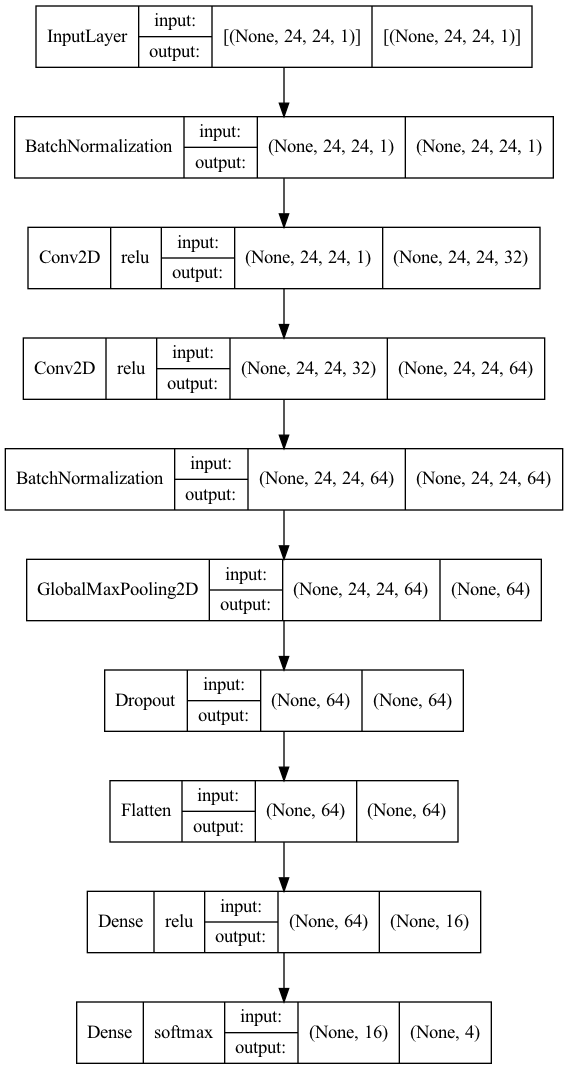

In [469]:
# Plot model architecture
plot_model(
    model,
    to_file="model_plot.png",
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
)

In [470]:
# Fit the model on the training data

# Using class weights to deal with the class imbalances:
# class_weight: Optional dictionary mapping class indices (integers) to a weight (float)
# value, used for weighting the loss function (during training only). This can be useful
# to tell the model to "pay more attention" to samples from an under-represented class.
# The weights were retrieved in the get_class_weights function higher up in this notebook

history = model.fit(
    im_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(im_val, y_val),
    class_weight=d_class_weights,
)

Epoch 1/50
4/4 [==============================] - 1s 111ms/step - loss: 3.9318 - acc: 0.4135 - f1_weighted: 0.2926 - val_loss: 1.3736 - val_acc: 0.3103 - val_f1_weighted: 0.2572
Epoch 2/50
4/4 [==============================] - 0s 58ms/step - loss: 1.7438 - acc: 0.2788 - f1_weighted: 0.2824 - val_loss: 1.3689 - val_acc: 0.3793 - val_f1_weighted: 0.2582
Epoch 3/50
4/4 [==============================] - 0s 56ms/step - loss: 1.6531 - acc: 0.2788 - f1_weighted: 0.2847 - val_loss: 1.3670 - val_acc: 0.3448 - val_f1_weighted: 0.2588
Epoch 4/50
4/4 [==============================] - 0s 53ms/step - loss: 1.5364 - acc: 0.3269 - f1_weighted: 0.2770 - val_loss: 1.3675 - val_acc: 0.3448 - val_f1_weighted: 0.2586
Epoch 5/50
4/4 [==============================] - 0s 55ms/step - loss: 1.3771 - acc: 0.3365 - f1_weighted: 0.2919 - val_loss: 1.3686 - val_acc: 0.3448 - val_f1_weighted: 0.2584
Epoch 6/50
4/4 [==============================] - 0s 52ms/step - loss: 1.3760 - acc: 0.3462 - f1_weighted: 0.3189 

In [471]:
# Predict on test set
y_pred = np.argmax(model.predict(im_test), axis=1)

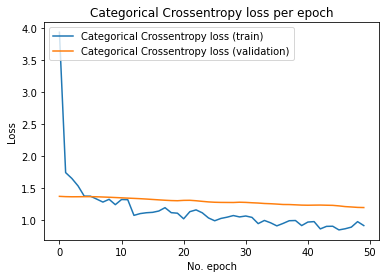

In [472]:
# Plot training and validation loss during training
plt.plot(history.history["loss"], label="Categorical Crossentropy loss (train)")
plt.plot(history.history["val_loss"], label="Categorical Crossentropy loss (validation)")
plt.title("Categorical Crossentropy loss per epoch")
plt.ylabel("Loss")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

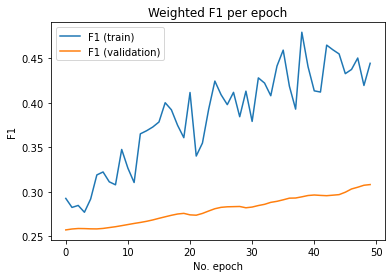

In [473]:
# Plot training and validation weighted f1 during training
plt.plot(history.history["f1_weighted"], label="F1 (train)")
plt.plot(history.history["val_f1_weighted"], label="F1 (validation)")
plt.title("Weighted F1 per epoch")
plt.ylabel("F1")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

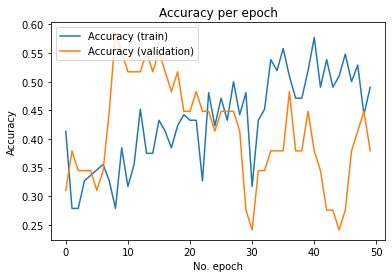

In [474]:
# Plot training and validation accuracy during training
plt.plot(history.history["acc"], label="Accuracy (train)")
plt.plot(history.history["val_acc"], label="Accuracy (validation)")
plt.title("Accuracy per epoch")
plt.ylabel("Accuracy")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

In [475]:
# Compute accuracy score on test set
accuracy = round(accuracy_score(np.argmax(y_val, axis=1), y_pred), 4)
print("Accuracy: " + str(accuracy))

# Compute precision score on test set
precision = round(precision_score(np.argmax(y_val, axis=1), y_pred, average="weighted"), 4)
print("Precision: " + str(precision))

# Compute F1 score on test set
F1 = round(f1_score(np.argmax(y_val, axis=1), y_pred, average="weighted"), 4)
print("Weighted F1: " + str(F1))

Accuracy: 0.2069
Precision: 0.1324
Weighted F1: 0.1584


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 15.0, 'Pred')

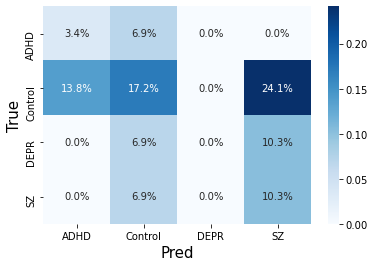

In [476]:
# Plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(
    cm / np.sum(cm),
    annot=True,
    fmt=".1%",
    cmap="Blues",
    xticklabels=["ADHD", "Control", "DEPR", "SZ"],
    yticklabels=["ADHD", "Control", "DEPR", "SZ"],
)
plt.ylabel("True", fontsize=15)  # x-axis label with fontsize 15
plt.xlabel("Pred", fontsize=15)  # y-axis label with fontsize 15

## Combining automatic feature extraction using CNN and manual feature extraction
We now attempt to combine features extracted automatically from the sequence data with manually defined features to see if this will increase model performance.

In [490]:
print(X_train_padded.shape)
print(X_val_padded.shape)
print(X_test_padded.shape)

(104, 2048)
(29, 2048)
(29, 2048)


In [645]:
# Convert to 1d array
X_train_padded_Man_Extracted = list(X_train_padded.ravel())
X_val_Man_Extracted = list(X_val_padded.ravel())
X_test_Man_Extracted = list(X_test_padded.ravel())

# Convert to Pandas Series
patients_train = pd.Series(list(range(0, X_train_padded.shape[0]))).repeat(X_train_padded.shape[1])
patients_val = pd.Series(list(range(0, X_val_padded.shape[0]))).repeat(X_val_padded.shape[1])
patients_test = pd.Series(list(range(0, X_test_padded.shape[0]))).repeat(X_test_padded.shape[1])

# Convert label from one-hot encoded vector to scalar
train_labels = get_label(y_train)
val_labels = get_label(y_val)
test_labels = get_label(y_test)

# Concatenate into Pandas DataFrame
train_df = pd.DataFrame(
    {
        "subject_id": patients_train,
        "activity": X_train_padded_Man_Extracted,
        "condition": train_labels,
    }
)
val_df = pd.DataFrame(
    {
        "subject_id": patients_val,
        "activity": X_val_Man_Extracted,
        "condition": val_labels,
    }
)
test_df = pd.DataFrame(
    {
        "subject_id": patients_test,
        "activity": X_test_Man_Extracted,
        "condition": test_labels,
    }
)

In [ ]:
# Extract manual features from each subject's sequences
train_df = manual_feature_builder(train_df)[0]
val_df = manual_feature_builder(val_df)[0]
test_df = manual_feature_builder(test_df)[0]

In [647]:
# Display the structure of the data
train_df

,subject_id,subject_id,activity,min,max,median,variance,kurtosis,cod,IQR,perc_zero_act,Label
0,0,-1.715476,-1.490074,-0.098533,-1.492904,-0.637789,-1.259819,1.221834,1.987782,-1.060279,1.218084,0
1,1,-1.682166,0.895999,-0.098533,2.079492,-0.637789,2.406727,-0.248992,0.035872,0.670773,0.616361,0
2,2,-1.648855,-1.425448,-0.098533,-1.806393,-0.637789,-1.274039,-0.278319,0.412360,-0.966346,0.957607,0
3,3,-1.615545,-1.408426,-0.098533,-1.562951,-0.637789,-1.253368,0.151396,0.778839,-1.013313,0.852608,1
4,4,-1.582235,-1.294604,-0.098533,-0.313588,-0.637789,-1.067987,2.222683,2.049556,-1.060279,1.470484,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,1.582235,-0.817767,-0.098533,-0.647747,-0.637789,-0.642307,-0.067907,0.795069,-0.919380,0.931357,0
100,100,1.615545,-0.794644,-0.098533,-0.675306,-0.637789,-0.697179,-0.194644,0.556162,-0.884155,0.741552,0
101,101,1.648855,-0.890536,-0.098533,-0.016176,-0.637789,-0.774882,0.860574,0.718382,-0.838865,0.695110,0
102,102,1.682166,0.147008,-0.098533,-0.116079,0.135979,-0.364880,-0.289009,-0.789903,0.336975,-1.394764,1


In [763]:
# Define the input layer
image_input = tf.keras.layers.Input(shape=(24, 24, 1), name="GramianAngularFields")
tabular_input = tf.keras.layers.Input(shape=(8), name="tabular")

# Add a 1D convolutional layer with 64 filters and a kernel size of 3
x = BatchNormalization()(image_input)
x = Conv2D(8, 2, strides=1, padding="same", activation="relu")(x)
x = Conv2D(16, 3, strides=1, padding="same", activation="relu")(x)
# x = Conv1D(64, 3, strides=1, activation='relu')(x)

x = BatchNormalization()(x)
x = GlobalMaxPooling2D()(x)
x = Dropout(rate=0.2)(x)
x = Flatten()(x)

# Define MLP which processes manual feature data
y = Dropout(rate=0.2)(tabular_input)
y = tf.keras.layers.Flatten()(y)
# y = tf.keras.layers.Dense(16, activation='relu', name="dense1_tabular")(y)
# y = tf.keras.layers.BatchNormalization()(y)

# Concatenate
merge = tf.keras.layers.concatenate([x, y], name="concat_images_tabular")

# Feed merge into final MLP
# Use batch normalization to standardize the output we get from the two datasets.
merge = tf.keras.layers.BatchNormalization()(merge)
merge = tf.keras.layers.Dense(16, activation="relu")(merge)
merge = tf.keras.layers.Dense(16, activation="relu")(merge)
output = tf.keras.layers.Dense(4, name="linear")(merge)

# Model with 2 inputs and 1 output
model = tf.keras.models.Model(inputs=[image_input, tabular_input], outputs=output)

# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# opt = tf.keras.optimizers.SGD(0.0001)

# Compile the model with an optimizer and a loss function
model.compile(
    optimizer=opt, loss="categorical_crossentropy", metrics=["acc", f1_weighted]
)
model.summary()

Model: "model_61"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GramianAngularFields (InputLay  [(None, 24, 24, 1)]  0          []                               
 er)                                                                                              
                                                                                                  
 batch_normalization_129 (Batch  (None, 24, 24, 1)   4           ['GramianAngularFields[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 conv2d_114 (Conv2D)            (None, 24, 24, 8)    40          ['batch_normalization_129[0][0]']
                                                                                           

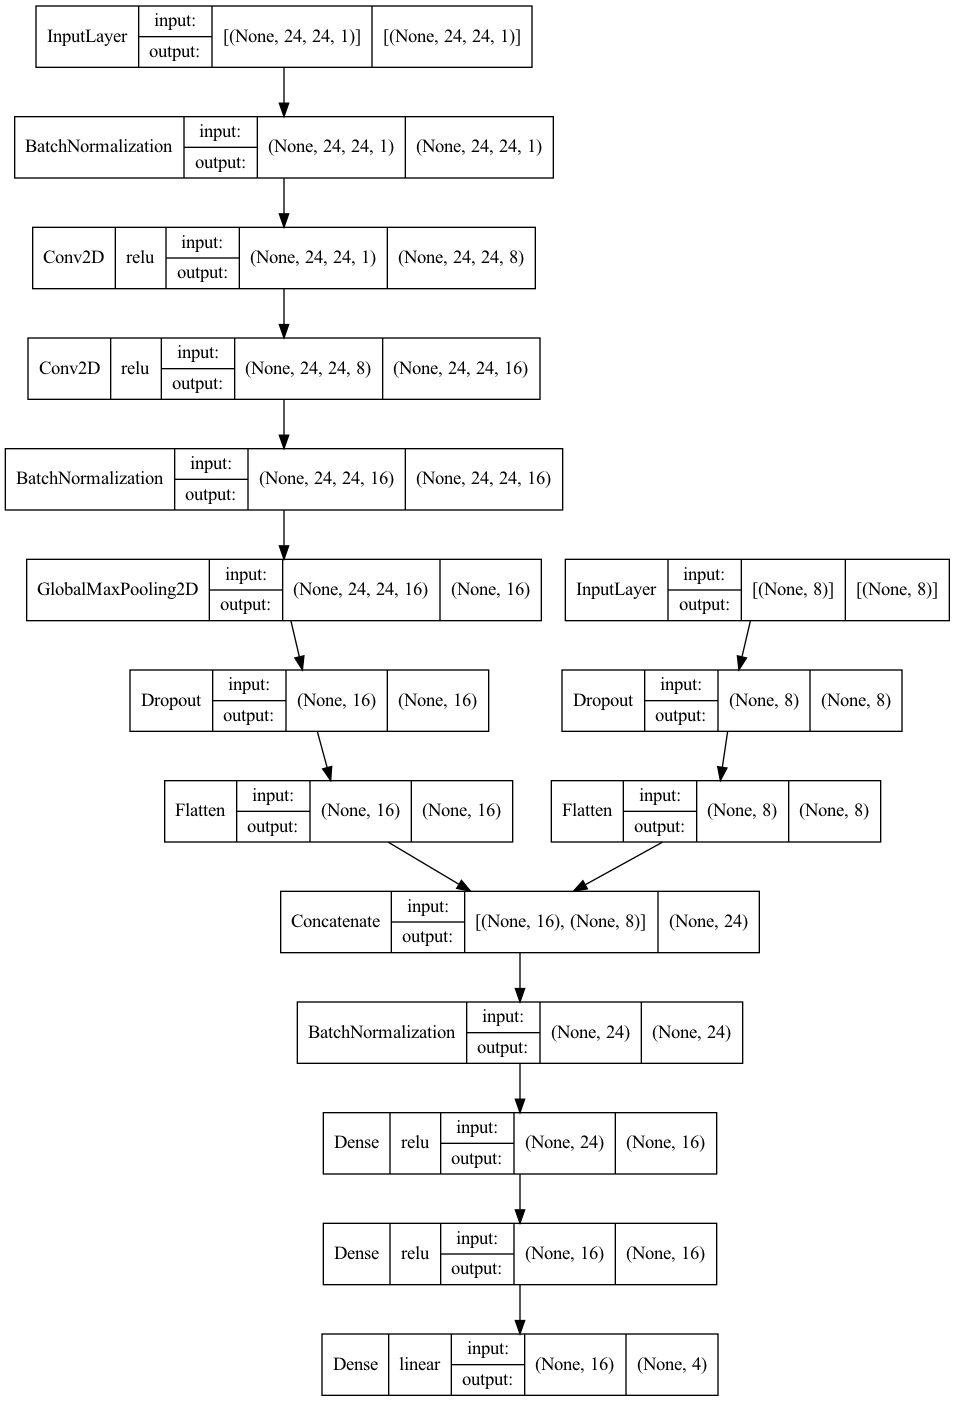

In [764]:
# Plot model architecture
plot_model(
    model,
    to_file="model_plot.png",
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
)

In [765]:
# Train model
tf.config.experimental_run_functions_eagerly(True)
history = model.fit(
    x=[
        im_train,
        train_df[
            [
                "min",
                "max",
                "median",
                "variance",
                "kurtosis",
                "cov",
                "IQR",
                "perc_zero_act",
            ]
        ],
    ],
    y=y_train,
    validation_data=(
        [
            im_val,
            val_df[
                [
                    "min",
                    "max",
                    "median",
                    "variance",
                    "kurtosis",
                    "cov",
                    "IQR",
                    "perc_zero_act",
                ]
            ],
        ],
        y_val,
    ),
    batch_size=64,
    epochs=50,
    verbose=True,
    class_weight=d_class_weights,
)

Epoch 1/50
1/2 [==============>...............] - ETA: 0s - loss: 7.9557 - acc: 0.4062 - f1_weighted: 0.5343

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 [==============================] - 0s 138ms/step - loss: 6.7890 - acc: 0.3750 - f1_weighted: 0.6248 - val_loss: 6.9101 - val_acc: 0.2069 - val_f1_weighted: 1.0336
Epoch 2/50
2/2 [==============================] - 0s 80ms/step - loss: 6.6944 - acc: 0.3942 - f1_weighted: 0.6656 - val_loss: 6.5335 - val_acc: 0.1379 - val_f1_weighted: 1.0639
Epoch 3/50


/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 [==============================] - 0s 84ms/step - loss: 7.1134 - acc: 0.3269 - f1_weighted: 0.6054 - val_loss: 6.8557 - val_acc: 0.1724 - val_f1_weighted: 1.0645
Epoch 4/50
2/2 [==============================] - 0s 100ms/step - loss: 7.3515 - acc: 0.3269 - f1_weighted: 0.5948 - val_loss: 6.8311 - val_acc: 0.1724 - val_f1_weighted: 1.0399
Epoch 5/50
2/2 [==============================] - 0s 102ms/step - loss: 5.7870 - acc: 0.2885 - f1_weighted: 0.5857 - val_loss: 6.8161 - val_acc: 0.3103 - val_f1_weighted: 1.0101
Epoch 6/50
2/2 [==============================] - 0s 113ms/step - loss: 6.5312 - acc: 0.3365 - f1_weighted: 0.6013 - val_loss: 7.9506 - val_acc: 0.3103 - val_f1_weighted: 0.9674
Epoch 7/50
2/2 [==============================] - 0s 103ms/step - loss: 8.3903 - acc: 0.3558 - f1_weighted: 0.6332 - val_loss: 8.0031 - val_acc: 0.3103 - val_f1_weighted: 0.9316
Epoch 8/50
2/2 [==============================] - 0s 108ms/step - loss: 7.1791 - acc: 0.3750 - f1_weighted: 0.6627 - val_l

In [766]:
# predict on test set
y_pred = np.argmax(
    model.predict(
        [
            im_test,
            test_df[
                [
                    "min",
                    "max",
                    "median",
                    "variance",
                    "kurtosis",
                    "cod",
                    "IQR",
                    "perc_zero_act",
                ]
            ],
        ]
    ),
    axis=1,
)

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


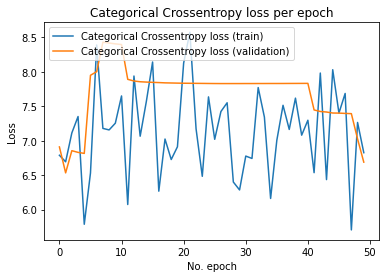

In [767]:
plt.plot(history.history["loss"], label="Categorical Crossentropy loss (train)")
plt.plot(history.history["val_loss"], label="Categorical Crossentropy loss (validation)")
plt.title("Categorical Crossentropy loss per epoch")
plt.ylabel("Loss")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

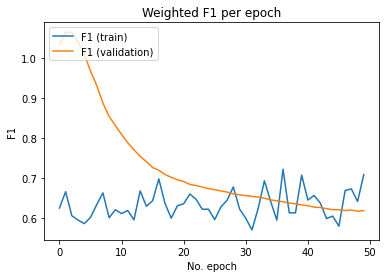

In [768]:
plt.plot(history.history["f1_weighted"], label="F1 (train)")
plt.plot(history.history["val_f1_weighted"], label="F1 (validation)")
plt.title("Weighted F1 per epoch")
plt.ylabel("F1")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

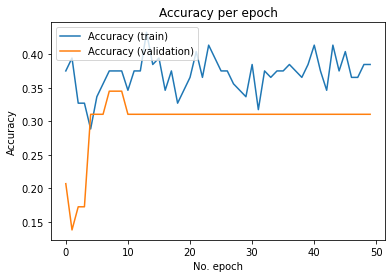

In [769]:
plt.plot(history.history["acc"], label="Accuracy (train)")
plt.plot(history.history["val_acc"], label="Accuracy (validation)")
plt.title("Accuracy per epoch")
plt.ylabel("Accuracy")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

In [770]:
# Compute accuracy score on test set
accuracy = round(accuracy_score(np.argmax(y_test, axis=1), y_pred), 4)
print("Accuracy: " + str(accuracy))

# Compute precision score on test set
precision = round(precision_score(np.argmax(y_test, axis=1), y_pred, average="weighted"), 4)
print("Precision: " + str(precision))

# Compute F1 score on test set
F1 = round(f1_score(np.argmax(y_test, axis=1), y_pred, average="weighted"), 4)
print("Weighted F1: " + str(F1))

Accuracy: 0.5517
Precision: 0.3044
Weighted F1: 0.3923


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 15.0, 'Pred')

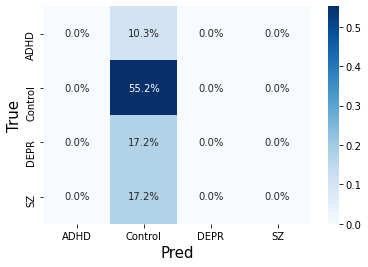

In [771]:
# Display confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(
    cm / np.sum(cm),
    annot=True,
    fmt=".1%",
    cmap="Blues",
    xticklabels=["ADHD", "Control", "DEPR", "SZ"],
    yticklabels=["ADHD", "Control", "DEPR", "SZ"],
)
plt.ylabel("True", fontsize=15)  # x-axis label with fontsize 15
plt.xlabel("Pred", fontsize=15)  # y-axis label with fontsize 15

## 1D CNN with night time data only

## Load data - night time data only

In [4]:
df = load_joint_dataset()
timeframe = ("18:00:00", "23:59:00")
df["time"] = df.timestamp.dt.time.astype(str)
df = df[(df.time >= timeframe[0]) & (timeframe[1] >= df.time)]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = convert_to_torch(
    df,
    slice_seq=False,
    preprocessing="average",
    k=10,
    train_perc=0.60,
    val_perc=0.20,
    random_seed=42,
    device=device,
)
train_data, val_data, test_data = data
X_train, y_train = list(zip(*train_data))
X_val, y_val = list(zip(*val_data))
X_test, y_test = list(zip(*test_data))

2022-12-23 21:15:27.315 | INFO     | load_data:load_depresjon:36 - Loading depresjon
2022-12-23 21:15:29.393 | INFO     | load_data:load_psykose:54 - Loading psykose
2022-12-23 21:15:30.242 | INFO     | load_data:load_hyperaktiv:72 - Loading hyperaktiv
2022-12-23 21:16:42.684 | INFO     | load_data:convert_to_torch:222 - Converting to torch
2022-12-23 21:16:42.685 | INFO     | load_data:convert_to_torch:225 - Filtering out problematic dates
2022-12-23 21:16:45.214 | INFO     | load_data:convert_to_torch:248 - Averaging activity sequences
2022-12-23 21:16:46.568 | INFO     | load_data:train_val_test_split:188 - Split dataset into
   Training set:
      59.86% of total sequences
      Subjects: ADHD: 36, ADHD_Control: 36, DEPR_Control: 27, SZ: 16, DEPR: 18
   Validation set:
      20.02% of total sequences
      Subjects: ADHD: 9, ADHD_Control: 4, DEPR_Control: 5, DEPR: 5, SZ: 6
   Test set:
      20.12% of total sequences
      Subjects: DEPR_Control: 7, ADHD: 7, ADHD_Control: 6, SZ: 5,

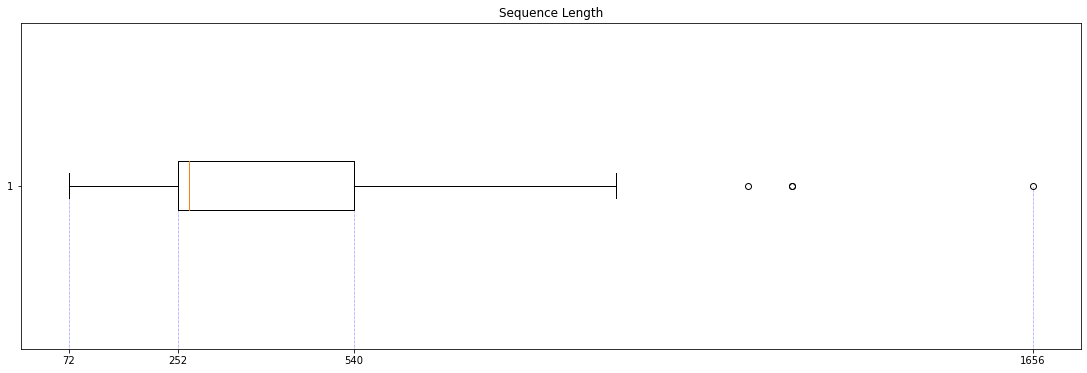

In [10]:
# Plot the distribution of sequence lengths
lengths = []
for i in range(len(X_train)):
    lengths.append((len(X_train[i])))

fig = plt.figure(1, figsize=(19, 6))
ax = fig.add_subplot(111)

ax.boxplot(lengths, vert=False, manage_ticks=True)
plt.title("Sequence Length")
ax.set_yticks([1])

quantiles = np.quantile(lengths, np.array([0.00, 0.25, 0.75, 1.00]))
ax.vlines(
    quantiles,
    [0] * quantiles.size,
    [1] * quantiles.size,
    color="b",
    ls=":",
    lw=0.5,
    zorder=0,
)
ax.set_ylim(0.5, 1.5)
ax.set_xticks(quantiles)
plt.show()

In [11]:
# Pad sequences
X_train_padded = pad_sequencer(X_train)
X_val_padded = pad_sequencer(X_val)
X_test_padded = pad_sequencer(X_test)

# Convert labels from Torch Tensor to Numpy Array
y_train = convert_torch_tensor_to_array(y_train)
y_val = convert_torch_tensor_to_array(y_val)
y_test = convert_torch_tensor_to_array(y_test)

# Convert shape from (#observations, #sequence_length, 1) to (#observations, #sequence_length)
X_train_padded = np.squeeze(X_train_padded)
X_val_padded = np.squeeze(X_val_padded)
X_test_padded = np.squeeze(X_test_padded)

print(X_train_padded.shape)
print(X_val_padded.shape)
print(X_test_padded.shape)

(104, 540)
(29, 540)
(29, 540)


## Create the model

In [71]:
# Define the input layer
inputs = Input(shape=(540, 1))  # shape=(timesteps, features)

# Add a 1D convolutional layer with 64 filters and a kernel size of 3
x = BatchNormalization()(inputs)
x = Conv1D(16, 2, strides=1, padding="same", activation="relu")(x)
x = Conv1D(32, 3, strides=1, padding="same", activation="relu")(x)
# x = Conv1D(64, 3, strides=1, activation='relu')(x)
x = BatchNormalization()(x)
x = GlobalMaxPooling1D()(x)  # Add a global max pooling layer
x = Dropout(rate=0.2)(x)
x = Flatten()(x)

# Final two dense layers
x = Dense(12, activation="relu")(x)
x = Dense(12, activation="relu")(x)
outputs = Dense(4, activation="softmax")(x)

# Create the model
model = keras.Model(inputs, outputs)

# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
# opt = tf.keras.optimizers.SGD(0.0001, momentum=0.9)

# Compile the model with an optimizer and a loss function
model.compile(
    optimizer=opt, loss="categorical_crossentropy", metrics=["acc", f1_weighted]
)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 540, 1)]          0         
                                                                 
 batch_normalization_14 (Bat  (None, 540, 1)           4         
 chNormalization)                                                
                                                                 
 conv1d_15 (Conv1D)          (None, 540, 16)           48        
                                                                 
 conv1d_16 (Conv1D)          (None, 540, 32)           1568      
                                                                 
 batch_normalization_15 (Bat  (None, 540, 32)          128       
 chNormalization)                                                
                                                                 
 global_max_pooling1d_7 (Glo  (None, 32)               0   

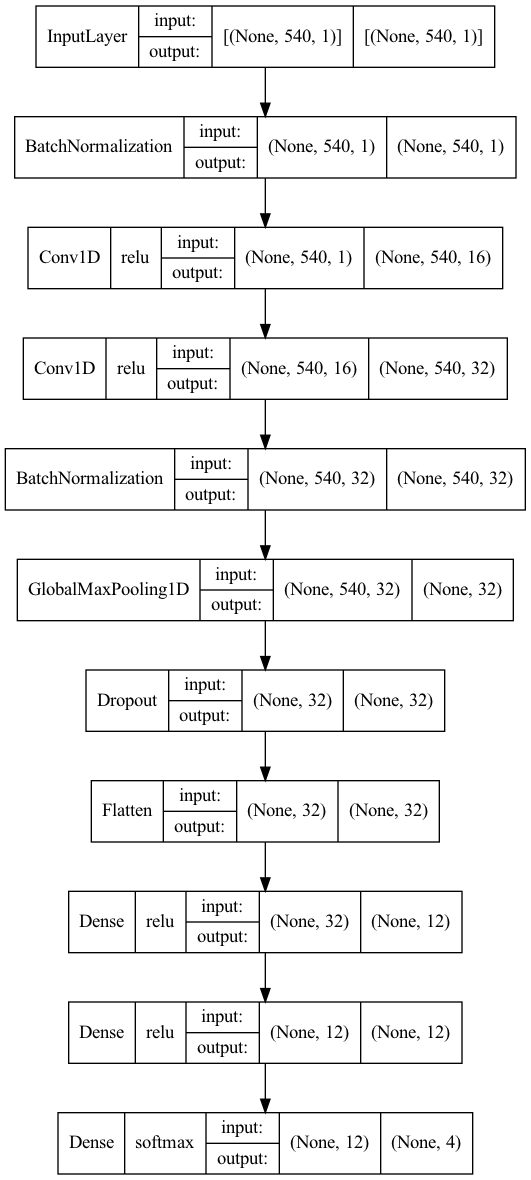

In [72]:
# Plot model architecture
plot_model(
    model,
    to_file="model_plot.png",
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
)

In [73]:
# Fit the model on the training data

# Using class weights to deal with the class imbalances:
# class_weight: Optional dictionary mapping class indices (integers) to a weight (float)
# value, used for weighting the loss function (during training only). This can be useful
# to tell the model to "pay more attention" to samples from an under-represented class.
# The weights were retrieved in the get_class_weights function higher up in this notebook

history = model.fit(
    X_train_padded,
    y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_val_padded, y_val),
    class_weight=d_class_weights,
)

Epoch 1/50
2/2 [==============================] - 1s 251ms/step - loss: 2.7973 - acc: 0.1442 - f1_weighted: 0.1855 - val_loss: 3.6839 - val_acc: 0.3103 - val_f1_weighted: 0.2164
Epoch 2/50
2/2 [==============================] - 0s 63ms/step - loss: 3.2531 - acc: 0.1442 - f1_weighted: 0.1753 - val_loss: 2.8532 - val_acc: 0.3103 - val_f1_weighted: 0.2260
Epoch 3/50
2/2 [==============================] - 0s 64ms/step - loss: 3.1821 - acc: 0.1731 - f1_weighted: 0.2008 - val_loss: 2.5117 - val_acc: 0.3103 - val_f1_weighted: 0.2299
Epoch 4/50
2/2 [==============================] - 0s 85ms/step - loss: 2.6491 - acc: 0.2019 - f1_weighted: 0.2253 - val_loss: 2.3258 - val_acc: 0.3103 - val_f1_weighted: 0.2321
Epoch 5/50
2/2 [==============================] - 0s 74ms/step - loss: 3.0794 - acc: 0.1923 - f1_weighted: 0.1951 - val_loss: 2.1961 - val_acc: 0.3103 - val_f1_weighted: 0.2337
Epoch 6/50
2/2 [==============================] - 0s 71ms/step - loss: 2.9895 - acc: 0.1923 - f1_weighted: 0.1857 

In [74]:
# Predict on test set
y_pred = np.argmax(model.predict(X_test_padded),axis=1)

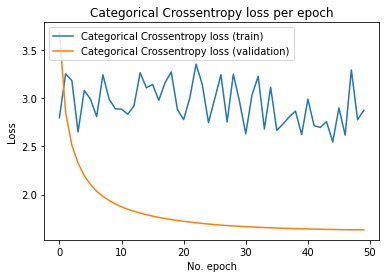

In [75]:
# Plot training and validation loss during training
plt.plot(history.history["loss"], label="Categorical Crossentropy loss (train)")
plt.plot(history.history["val_loss"], label="Categorical Crossentropy loss (validation)")
plt.title("Categorical Crossentropy loss per epoch")
plt.ylabel("Loss")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

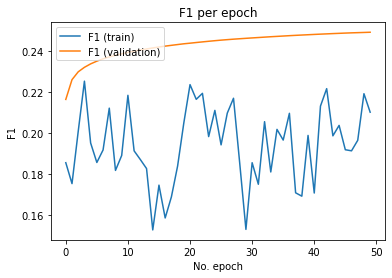

In [76]:
# Plot training and validation weighted f1 during training
plt.plot(history.history["f1_weighted"], label="F1 (train)")
plt.plot(history.history["val_f1_weighted"], label="F1 (validation)")
plt.title("F1 per epoch")
plt.ylabel("F1")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

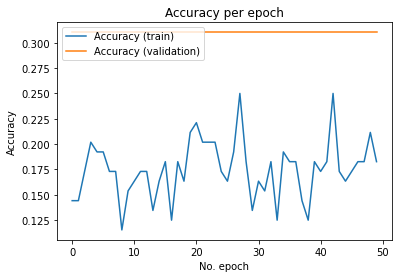

In [77]:
# Plot training and validation accuracy during training
plt.plot(history.history["acc"], label="Accuracy (train)")
plt.plot(history.history["val_acc"], label="Accuracy (validation)")
plt.title("Accuracy per epoch")
plt.ylabel("Accuracy")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

In [78]:
# Compute accuracy score on test set
accuracy = round(accuracy_score(np.argmax(y_test, axis=1), y_pred), 4)
print("Accuracy: " + str(accuracy))

# Compute precision score on test set
precision = round(precision_score(np.argmax(y_test, axis=1), y_pred, average="weighted"), 4)
print("Precision: " + str(precision))

# Compute F1 score on test set
F1 = round(f1_score(np.argmax(y_test, axis=1), y_pred, average="weighted"), 4)
print("Weighted F1: " + str(F1))

Accuracy: 0.5517
Precision: 0.3044
Weighted F1: 0.3923


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 15.0, 'Pred')

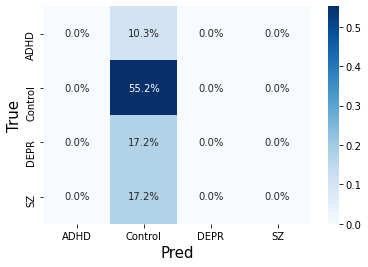

In [79]:
# Display confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(
    cm / np.sum(cm),
    annot=True,
    fmt=".1%",
    cmap="Blues",
    xticklabels=["ADHD", "Control", "DEPR", "SZ"],
    yticklabels=["ADHD", "Control", "DEPR", "SZ"],
)
plt.ylabel("True", fontsize=15)  # x-axis label with fontsize 15
plt.xlabel("Pred", fontsize=15)  # y-axis label with fontsize 15

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ab8721ad-d9fd-4aa4-9e40-aaf77e0bccf1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>